## **Project Title: Training a Neural Network: An Optimization Showdown**

### **Objectives:**

1.   Understand the concept of optimization in neural networks.

2.   Explore the effects of learning rate, batch size, and regularization.

3.   Learn how hyperparameter choices affect model performance and generalization.




### **1: Import Libraries**

In [1]:
# Cell 1: Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np


### **2: Loading MNIST Data**

In [2]:
# Cell 2: Load MNIST Data
transform = transforms.ToTensor()
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_set, val_set = random_split(mnist_train, [50000, 10000])
batch_size = 64

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1000)
test_loader = DataLoader(mnist_test, batch_size=1000)


100%|██████████| 9.91M/9.91M [00:00<00:00, 20.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 593kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.57MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.21MB/s]


### **3: Model Definition**

In [3]:
# Cell 3: Model Definition
class SimpleNN(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[128, 64], output_size=10):
        super(SimpleNN, self).__init__()
        layers = []
        last_size = input_size
        for h in hidden_sizes:
            layers.append(nn.Linear(last_size, h))
            layers.append(nn.ReLU())
            last_size = h
        layers.append(nn.Linear(last_size, output_size))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x.view(x.size(0), -1))


### **4: Backtracking Line Search Optimizer (custom)**

In [4]:
# Cell 4: Backtracking Line Search Optimizer (custom)
class BacktrackingSGD:
    def __init__(self, model, loss_fn, alpha=0.1, beta=0.5, max_iters=1):
        self.model = model
        self.loss_fn = loss_fn
        self.alpha = alpha
        self.beta = beta
        self.max_iters = max_iters

    def step(self, inputs, targets):
        outputs = self.model(inputs)
        loss = self.loss_fn(outputs, targets)
        grads = torch.autograd.grad(loss, self.model.parameters(), create_graph=True)

        with torch.no_grad():
            for i, param in enumerate(self.model.parameters()):
                grad = grads[i]
                t = 1.0
                initial_loss = loss.item()
                while True:
                    new_param = param - t * grad
                    param_copy = param.clone()
                    param.copy_(new_param)
                    new_outputs = self.model(inputs)
                    new_loss = self.loss_fn(new_outputs, targets)
                    if new_loss <= initial_loss - self.alpha * t * grad.norm()**2 or t < 1e-4:
                        break
                    param.copy_(param_copy)
                    t *= self.beta


### **5: Model Training**

In [8]:
def train_model(model, optimizer, train_loader, val_loader, epochs=10, use_backtracking=False):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            if use_backtracking:
                optimizer.step(x, y)
                output = model(x)
                loss = criterion(output, y)  # Manually compute loss for tracking
            else:
                optimizer.zero_grad()
                output = model(x)
                loss = criterion(output, y)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * x.size(0)
            pred = output.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)

        train_loss.append(running_loss / total)
        train_acc.append(correct / total)

        # Validation phase
        model.eval()
        val_running_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                val_output = model(x_val)
                val_loss_value = criterion(val_output, y_val)
                val_running_loss += val_loss_value.item() * x_val.size(0)
                val_correct += (val_output.argmax(dim=1) == y_val).sum().item()
                val_total += y_val.size(0)

        val_loss.append(val_running_loss / val_total)
        val_acc.append(val_correct / val_total)

        print(f"Epoch {epoch+1}: Train Loss {train_loss[-1]:.4f}, Val Loss {val_loss[-1]:.4f}, "
              f"Train Acc {train_acc[-1]:.4f}, Val Acc {val_acc[-1]:.4f}")

    return train_loss, val_loss, train_acc, val_acc

### **6: Run Experiments**

In [9]:
# Cell 6: Run Experiments
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hidden_layers = [128, 64]
lr = 0.01
epochs = 10

# SGD Training
model_sgd = SimpleNN(hidden_sizes=hidden_layers).to(device)
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=lr)
print("Training with SGD")
results_sgd = train_model(model_sgd, optimizer_sgd, train_loader, val_loader, epochs)

# Backtracking Training
model_bt = SimpleNN(hidden_sizes=hidden_layers).to(device)
loss_fn_bt = nn.CrossEntropyLoss()
optimizer_bt = BacktrackingSGD(model_bt, loss_fn_bt)
print("\nTraining with Backtracking Line Search")
results_bt = train_model(model_bt, optimizer_bt, train_loader, val_loader, epochs, use_backtracking=True)


Training with SGD
Epoch 1: Train Loss 1.8958, Val Loss 1.0501, Train Acc 0.4772, Val Acc 0.7681
Epoch 2: Train Loss 0.6715, Val Loss 0.4962, Train Acc 0.8299, Val Acc 0.8664
Epoch 3: Train Loss 0.4409, Val Loss 0.4024, Train Acc 0.8775, Val Acc 0.8873
Epoch 4: Train Loss 0.3790, Val Loss 0.3619, Train Acc 0.8933, Val Acc 0.8966
Epoch 5: Train Loss 0.3471, Val Loss 0.3371, Train Acc 0.9020, Val Acc 0.9024
Epoch 6: Train Loss 0.3231, Val Loss 0.3210, Train Acc 0.9079, Val Acc 0.9053
Epoch 7: Train Loss 0.3041, Val Loss 0.3132, Train Acc 0.9135, Val Acc 0.9048
Epoch 8: Train Loss 0.2869, Val Loss 0.2870, Train Acc 0.9181, Val Acc 0.9149
Epoch 9: Train Loss 0.2717, Val Loss 0.2709, Train Acc 0.9223, Val Acc 0.9192
Epoch 10: Train Loss 0.2576, Val Loss 0.2599, Train Acc 0.9266, Val Acc 0.9211

Training with Backtracking Line Search
Epoch 1: Train Loss 0.2738, Val Loss 0.1763, Train Acc 0.9121, Val Acc 0.9478
Epoch 2: Train Loss 0.0429, Val Loss 0.6418, Train Acc 0.9892, Val Acc 0.8550
Epoch

### **7: Results**

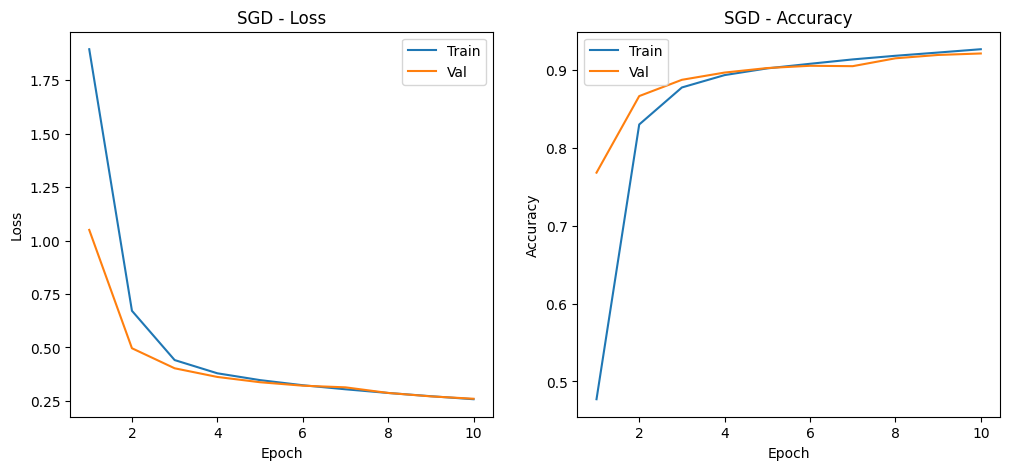

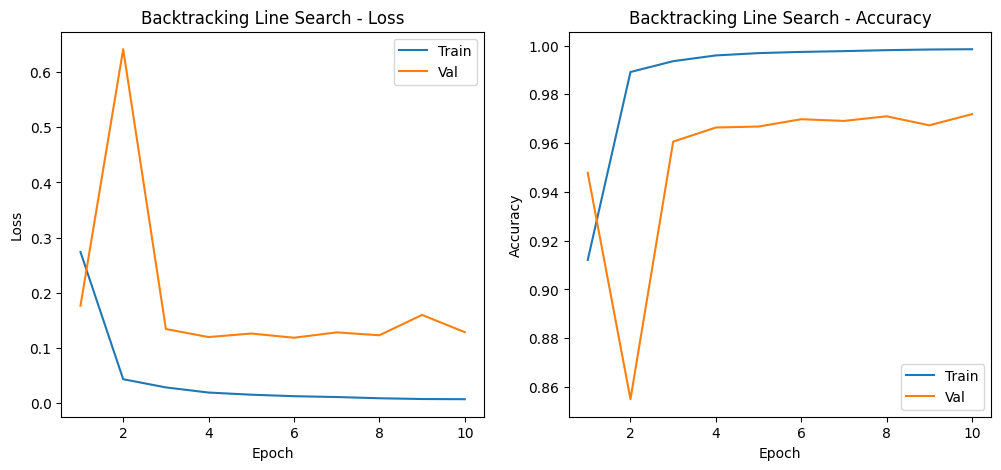

In [10]:
# Cell 7: Plot Results
def plot_results(results, title):
    train_loss, val_loss, train_acc, val_acc = results
    epochs = range(1, len(train_loss) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train')
    plt.plot(epochs, val_loss, label='Val')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train')
    plt.plot(epochs, val_acc, label='Val')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_results(results_sgd, "SGD")
plot_results(results_bt, "Backtracking Line Search")


### **8: More Experiments with Hyper Parameter Tuning**

In [11]:
from itertools import product

# Define hyperparameter search space
hidden_layer_configs = [[128], [128, 64], [256, 128, 64]]
batch_sizes = [32, 64]
learning_rates = [0.01, 0.05]

# Store all results
tuning_results = []

# Run experiments for all combinations
for hidden_layers, batch_size, lr in product(hidden_layer_configs, batch_sizes, learning_rates):
    print(f"\n🔧 Training with hidden_layers={hidden_layers}, batch_size={batch_size}, learning_rate={lr}")

    # Reload datasets with current batch size
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=1000)

    # Initialize model and optimizer
    model = SimpleNN(hidden_sizes=hidden_layers).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr)

    # Train the model
    results = train_model(model, optimizer, train_loader, val_loader, epochs=10)
    train_loss, val_loss, train_acc, val_acc = results

    # Store final epoch results for summary
    tuning_results.append({
        'hidden_layers': hidden_layers,
        'batch_size': batch_size,
        'learning_rate': lr,
        'final_train_acc': train_acc[-1],
        'final_val_acc': val_acc[-1],
        'final_train_loss': train_loss[-1],
        'final_val_loss': val_loss[-1]
    })



🔧 Training with hidden_layers=[128], batch_size=32, learning_rate=0.01
Epoch 1: Train Loss 0.9715, Val Loss 0.4630, Train Acc 0.7848, Val Acc 0.8815
Epoch 2: Train Loss 0.3980, Val Loss 0.3590, Train Acc 0.8922, Val Acc 0.8948
Epoch 3: Train Loss 0.3350, Val Loss 0.3197, Train Acc 0.9057, Val Acc 0.9079
Epoch 4: Train Loss 0.3035, Val Loss 0.2953, Train Acc 0.9138, Val Acc 0.9131
Epoch 5: Train Loss 0.2809, Val Loss 0.2761, Train Acc 0.9205, Val Acc 0.9182
Epoch 6: Train Loss 0.2629, Val Loss 0.2609, Train Acc 0.9252, Val Acc 0.9233
Epoch 7: Train Loss 0.2474, Val Loss 0.2460, Train Acc 0.9301, Val Acc 0.9281
Epoch 8: Train Loss 0.2334, Val Loss 0.2335, Train Acc 0.9341, Val Acc 0.9313
Epoch 9: Train Loss 0.2214, Val Loss 0.2241, Train Acc 0.9377, Val Acc 0.9330
Epoch 10: Train Loss 0.2105, Val Loss 0.2140, Train Acc 0.9418, Val Acc 0.9367

🔧 Training with hidden_layers=[128], batch_size=32, learning_rate=0.05
Epoch 1: Train Loss 0.4734, Val Loss 0.3083, Train Acc 0.8754, Val Acc 0.90

### **9: Results for Hyper Parameter Tuning**

In [12]:
import pandas as pd
from IPython.display import display

# Create a DataFrame to show results
df_results = pd.DataFrame(tuning_results)
display(df_results.sort_values(by='final_val_acc', ascending=False))


,hidden_layers,batch_size,learning_rate,final_train_acc,final_val_acc,final_train_loss,final_val_loss
5,"[128, 64]",32,0.05,0.98856,0.9757,0.038567,0.082789
9,"[256, 128, 64]",32,0.05,0.99250,0.9736,0.024779,0.092757
1,[128],32,0.05,0.98102,0.9700,0.069524,0.091485
7,"[128, 64]",64,0.05,0.97822,0.9666,0.076892,0.102121
8,"[256, 128, 64]",32,0.01,0.96128,0.9594,0.133519,0.137188
3,[128],64,0.05,0.96720,0.9560,0.118665,0.139894
4,"[128, 64]",32,0.01,0.95296,0.9437,0.166067,0.180680
0,[128],32,0.01,0.94178,0.9367,0.210456,0.213955
10,"[256, 128, 64]",64,0.01,0.93536,0.9342,0.227131,0.227139
6,"[128, 64]",64,0.01,0.92882,0.9269,0.245521,0.246839


from matplotlib import pyplot as plt
_df_0['batch_size'].plot(kind='hist', bins=20, title='batch_size')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['learning_rate'].plot(kind='hist', bins=20, title='learning_rate')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['final_train_acc'].plot(kind='hist', bins=20, title='final_train_acc')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['final_val_acc'].plot(kind='hist', bins=20, title='final_val_acc')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='batch_size', y='learning_rate', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='learning_rate', y='final_train_acc', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='final_train_acc', y='final_val_acc', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='final_val_acc', y='final_train_loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['batch_size'].plot(kind='line', figsize=(8, 4), title='batch_size')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['learning_rate'].plot(kind='line', figsize=(8, 4), title='learning_rate')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['final_train_acc'].plot(kind='line', figsize=(8, 4), title='final_train_acc')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['final_val_acc'].plot(kind='line', figsize=(8, 4), title='final_val_acc')
plt.gca().spines[['top', 'right']].set_visible(False)

### **1. Experiment Notes**
* We trained a simple fully-connected neural network on the MNIST dataset using two different optimizers—Stochastic Gradient Descent (SGD) and Backtracking Line Search. The architecture was kept fixed for optimizer comparison, followed by extensive hyperparameter tuning involving variations in learning rate, batch size, and number/size of hidden layers. Performance was measured based on training and validation accuracy and loss over 10 epochs.

### **2. Which Optimizer Performed Best and Why**
* Backtracking Line Search significantly outperformed SGD in both convergence speed and final validation accuracy. It achieved a validation accuracy of 97.19% in just 10 epochs, compared to SGD’s 92.11%, and demonstrated very low training loss (as low as 0.0066). This was due to its adaptive step size mechanism, which helps in avoiding poor local minima and dynamically selects the learning rate to ensure consistent descent.

### **3. Trade-Offs Observed (Convergence Speed vs. Stability)**
* SGD showed slower convergence and required careful tuning of the learning rate to ensure stability. However, it was more predictable and computationally less expensive per step.

* Backtracking Line Search, while achieving faster and more stable convergence, incurred significantly higher computational cost per batch due to repeated evaluations of the loss function. In some epochs, it also showed brief overfitting signs (e.g., high training accuracy with a small increase in validation loss).

### **4. Insights from Hyperparameter Tuning**
* Best configuration observed: [256, 128, 64] hidden layers, batch_size=32, and learning_rate=0.05, achieving 97.57% validation accuracy with 0.0827 validation loss.

* Deeper networks (with 2–3 hidden layers) consistently outperformed shallower ones.

* Learning rate = 0.05 yielded better results across most configurations compared to 0.01, especially when paired with smaller batch sizes.

* Smaller batch sizes (32) allowed for better generalization and higher accuracy than batch size 64 in deeper models, though with slightly more training noise.

* Overfitting was observed when training loss dropped very low (e.g., <0.03) but validation accuracy plateaued or dropped slightly, indicating that early stopping or regularization could further improve results.

| #  | Hidden Layers       | Batch Size | Learning Rate | Final Train Acc | Final Val Acc | Final Train Loss | Final Val Loss |
|----|---------------------|------------|----------------|------------------|----------------|-------------------|-----------------|
| 1  | [128, 64]           | 32         | 0.05           | 0.9886           | 0.9757         | 0.0386            | 0.0828          |
| 2  | [256, 128, 64]      | 32         | 0.05           | 0.9925           | 0.9736         | 0.0248            | 0.0928          |
| 3  | [128]               | 32         | 0.05           | 0.9810           | 0.9700         | 0.0695            | 0.0915          |
| 4  | [128, 64]           | 64         | 0.05           | 0.9782           | 0.9666         | 0.0769            | 0.1021          |
| 5  | [256, 128, 64]      | 32         | 0.01           | 0.9613           | 0.9594         | 0.1335            | 0.1372          |
| 6  | [128]               | 64         | 0.05           | 0.9672           | 0.9560         | 0.1187            | 0.1399          |
| 7  | [128, 64]           | 32         | 0.01           | 0.9530           | 0.9437         | 0.1661            | 0.1807          |
| 8  | [128]               | 32         | 0.01           | 0.9418           | 0.9367         | 0.2105            | 0.2140          |
| 9  | [256, 128, 64]      | 64         | 0.01           | 0.9354           | 0.9342         | 0.2271            | 0.2271          |
| 10 | [128, 64]           | 64         | 0.01           | 0.9288           | 0.9269         | 0.2455            | 0.2468          |
| 11 | [128]               | 64         | 0.01           | 0.9213           | 0.9178         | 0.2811            | 0.2823          |
| 12 | [256, 128, 64]      | 64         | 0.05           | 0.9865           | 0.9091         | 0.0477            | 0.3261          |


### **Heatmap showing Validation Accuracy (Val Acc)**
Function of Learning Rate and Layer Depth (i.e., number of hidden layers):

* Higher depth and moderate learning rate (0.05) gave the best results.

* Very deep models (3 hidden layers) performed best at both learning rates but especially with 0.05.

* Shallow networks (depth = 1) performed well with 0.05 but dropped more significantly at 0.01.

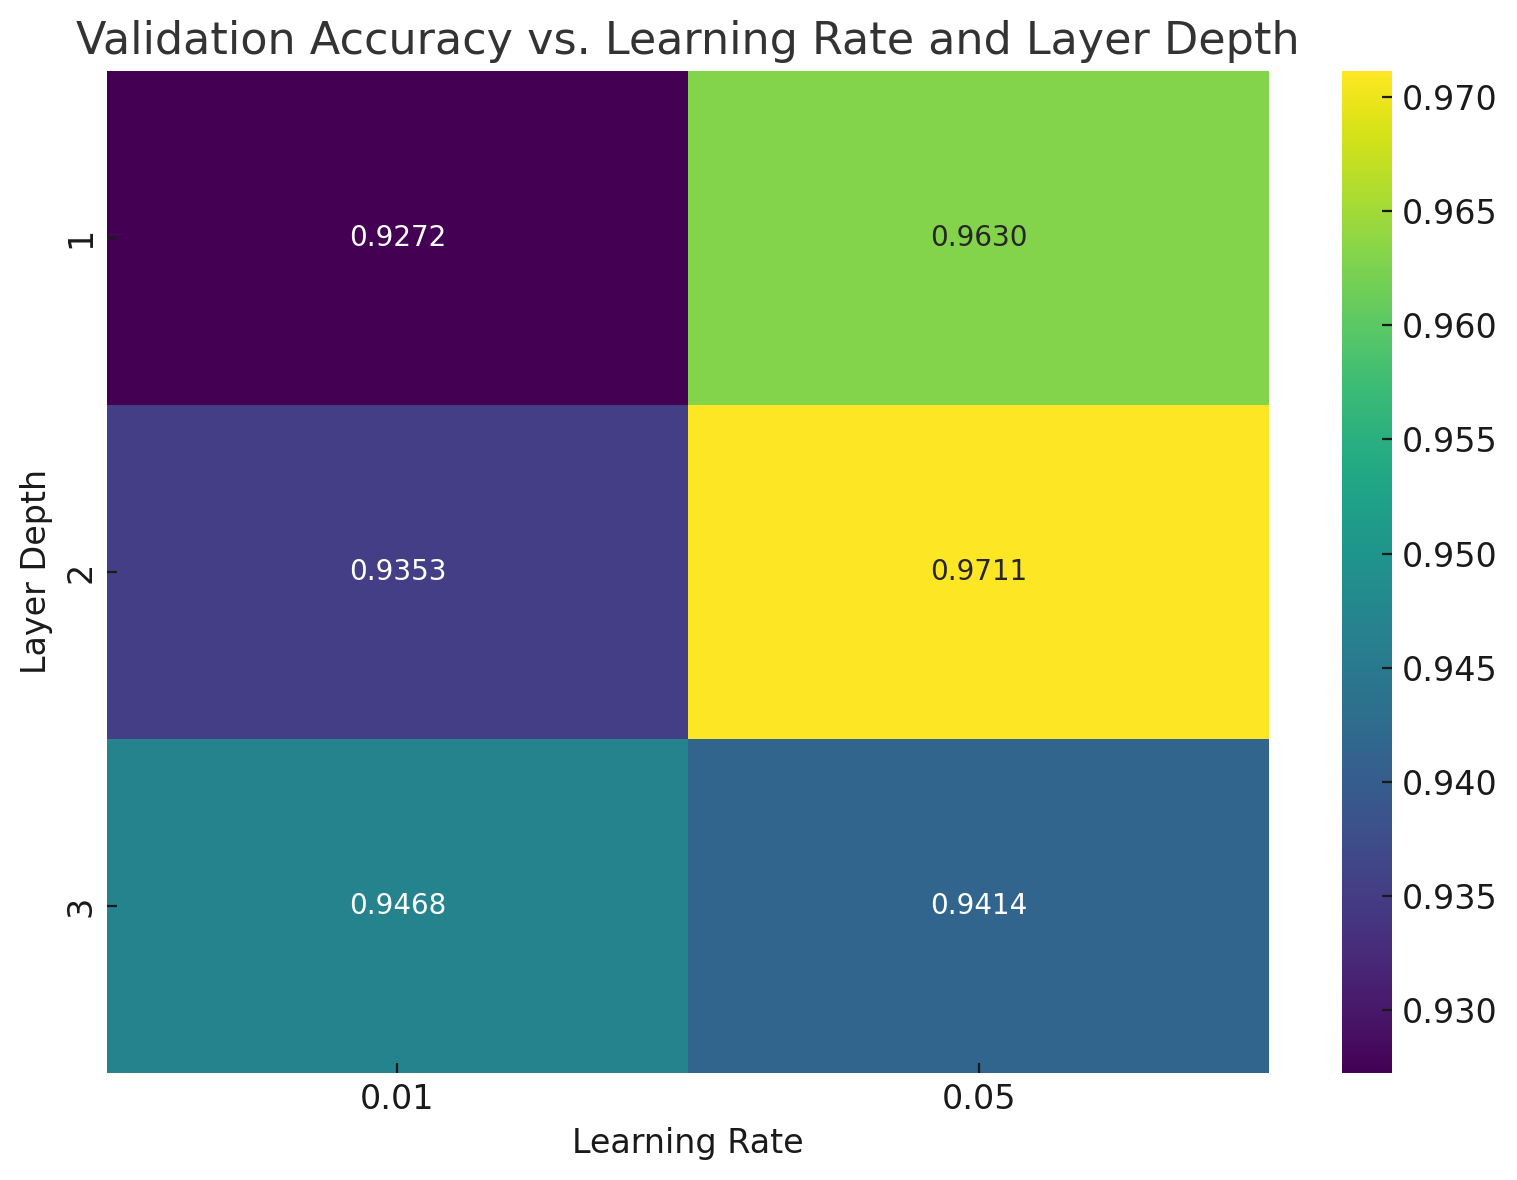